In [14]:
from dataloader import get_dataloaders, load_samples_dataset
from samples_dataset import SamplesDataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

%matplotlib widget 
from matplotlib import pyplot as plt

# Train method

In [15]:
def train(model, dataloader, optimizer, criterion, n_epoch=10, verbose=False):
    device = next(model.parameters()).device
    mean_loss = []
    nb_examples = len(dataloader.dataset)

    model.train(True)
    for epoch in tqdm(range(n_epoch)):  # loop over the dataset multiple times
        loss_sum = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)[:,0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
        mean_loss.append(loss_sum / nb_examples)

    if verbose:
        print('Finished Training')
        plt.title('Mean error for each epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Mean error')
        plt.plot(range(1, n_epoch + 1), mean_loss)

# Test method

In [16]:
def test(model, dataloader, verbose=False):
    device = next(model.parameters()).device

    model.eval()
    
    with torch.no_grad():
        accuracy = 0.0
        nb_examples = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            nb_examples += len(inputs)

            outputs = model(inputs)[:,0]
            accuracy += torch.sum(outputs == labels).item()

        accuracy /= nb_examples
        return accuracy * 100

# Cross-validation method

In [17]:
def cross_valisation(model, X, y, optimizer, criterion, k=10, n_epoch=50):
    scores = list()

    if len(X) != len(y):
            raise Exception(f'The size of X {len(X)} must be the same as the size y {len(y)}.')
    
    dataset_X_folds = np.array_split(X, k)
    dataset_y_folds = np.array_split(y, k)

    print(f'Starting {k}-fold cross-validation.')
    pbar = tqdm(range(k), bar_format='Cross-validation performed at {percentage:3.0f}%{bar}{r_bar}')
    for i in pbar:
        samples_train = SamplesDataset()
        dataset_X_train = np.concatenate(dataset_X_folds[0:i] + dataset_X_folds[i+1: len(dataset_X_folds)])
        dataset_y_train = np.concatenate(dataset_y_folds[0:i] + dataset_y_folds[i+1: len(dataset_y_folds)])
        samples_train.add_examples(dataset_X_train, dataset_y_train)

        samples_test = SamplesDataset()
        dataset_X_test = dataset_X_folds[i]
        dataset_y_test = dataset_y_folds[i]
        samples_test.add_examples(dataset_X_test, dataset_y_test)

        train_dataloader = DataLoader(samples_train, batch_size=64, shuffle=True, pin_memory=True)
        test_dataloader = DataLoader(samples_test, batch_size=64, shuffle=True, pin_memory=True)

        train(model=model, dataloader=train_dataloader, optimizer=optimizer, criterion=criterion, n_epoch=n_epoch)
        score = test(model=model, dataloader=test_dataloader)

        scores.append(score)

    return np.array(scores)

# Main

## Loading data

In [18]:
full_dataset = load_samples_dataset()
full_dataset.shuffle()
dataset_X, dataset_y = full_dataset.get_row_dataset()

Creating positive examples.


  0%|          | 0/649 [00:00<?, ?it/s]

Creating negative examples.


  0%|          | 0/7326 [00:00<?, ?it/s]

Dataset size : 14652


(14652, 70)


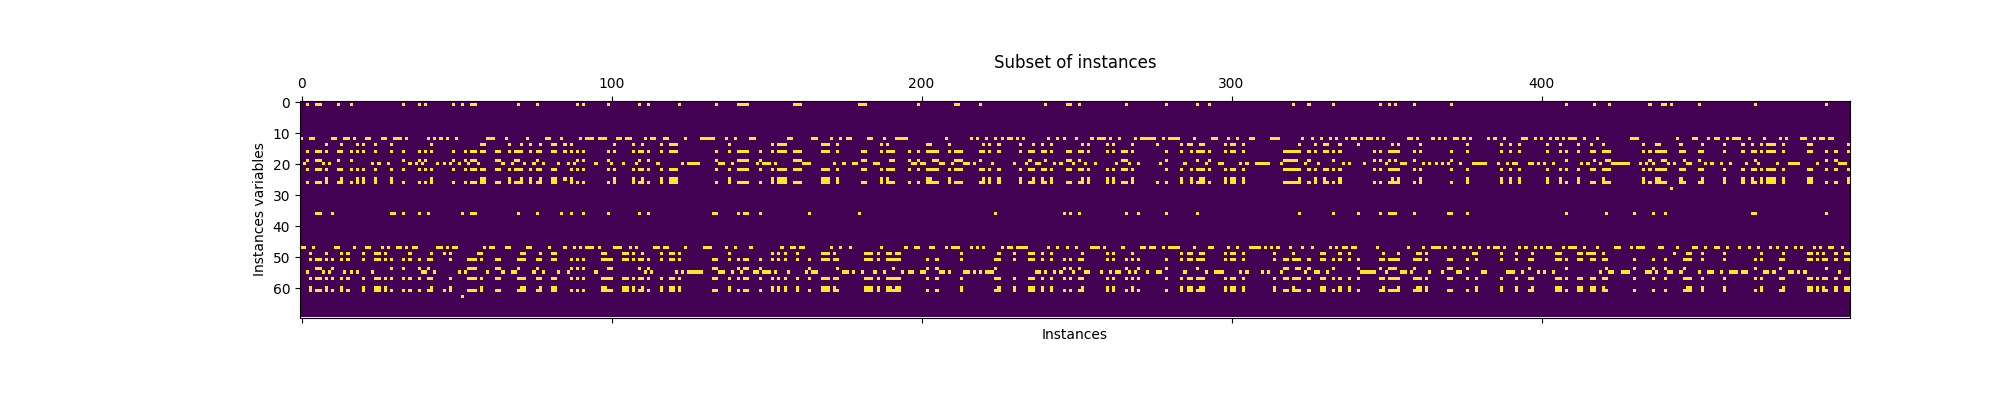

Matrix is 93.74% sparse


In [19]:
matrix = np.matrix(dataset_X)
matrix = matrix
print(matrix.shape)

bin_matrix = matrix.copy()
bin_matrix[bin_matrix > 0] = 1

plot_matrix = bin_matrix[:500,:].T

matfig = plt.figure(figsize=(20,4))
plt.matshow(plot_matrix, fignum=matfig.number)
plt.title('Subset of instances')
plt.xlabel('Instances')
plt.ylabel('Instances variables')
plt.show()

sparsisty = np.count_nonzero(matrix == 0) / matrix.size
print(f'Matrix is {100 * sparsisty:3.2f}% sparse')


## Creating model

In [20]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

n_hidden = 35
model = nn.Sequential(
    nn.Linear(70, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 1),
    nn.Sigmoid()
)

model.to(device)

print(f'Model: {model}')
print(f'Model on device : {next(model.parameters()).device}.')

criterion = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Model: Sequential(
  (0): Linear(in_features=70, out_features=35, bias=True)
  (1): ReLU()
  (2): Linear(in_features=35, out_features=1, bias=True)
  (3): Sigmoid()
)
Model on device : cpu.


## Perfoming cross-validation

In [21]:
k = 7
scores = cross_valisation(model=model, X=dataset_X, y=dataset_y, optimizer=optimizer, criterion=criterion, k=k, n_epoch=20)
print(f'Score mean : {scores.mean()}')
print(f'Score standard deviation : {scores.std()}')

plt.title('Accuracy for each cross-validation iteration')
plt.xlabel('Iteration number')
plt.ylabel('Score')
plt.plot(range(1, k + 1), scores)

Starting 7-fold cross-validation.


Cross-validation performed at   0%          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Score mean : 37.64066617917016
Score standard deviation : 4.72835391179165
